# Programmatic Data Wrangling
## A Brief Summary Of Movie Data Through The Last Century
##### by Carl Atterbury

In [259]:
## Importing libraries and data

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm        # sourced from ChatGPT to help maintain colour consistency
import re

movies_data = r"C:\Users\carla\Documents\Digital Futures\TMDB_movies.csv"
df = pd.read_csv(movies_data)

## Financial Performance

While evaluating the data provided, it became clear that we have a number of entries where financial data is not provided. There appear to be a number of possible explanations for this, including missing revenue data for movies classifield as 'TV Movie' in genre:

```Python
tv_movies = df.loc[df.genres.str.contains('TV Movie')]
tv_movies
```

For the purposes of initial analysis I have chosen to filter the data to remove such entries for financial visualisations. While it may be important to filter for low/negative values as part of some analyses, this investigation is concerned with trends over time. As such, 0 values can skew the data when applied uncriticially, and we currently lack metadata to understand the gaps.

*N.B. following code exemplifies a movie which we can know has a budget, but is unreported in the data*  
<br>
### Budget/Revenue Performance over time

First we will look at the general financial trends of movies over the past century:

In [179]:
## Creating additional columns for use during data analysis

df.release_date = pd.to_datetime(df.release_date)                         # ensuring release_date is converted to datetime for pandas operation
df['profit'] = df.revenue - df.budget
df['release_yr'] = df.release_date.dt.year                                # separating year into it's own column
df['release_qtr'] = df.release_date.dt.quarter                            # separating quarter into it's own column
df['decade'] = (df.release_yr // 10)* 10                                  # creating a column to designate 'decade' attribute

## Creating filters to manipulate tables based on incomplete budget/revenue data

df_no_budget = df[(df.budget == 0) & (df.revenue != 0)]
df_no_rev = df[(df.revenue == 0) & (df.budget != 0)]
df_no_finance = df[(df.budget == 0) & (df.revenue == 0)]
df_budget = df[(df.budget != 0) & (df.revenue == 0)]
df_revenue = df[(df.revenue != 0) & (df.budget == 0)]
df_finance = df[(df.budget != 0) & (df.revenue != 0)]

df_no_finance_filt = pd.concat([df_no_budget, df_no_rev, df_no_finance])   # rows containing *no* finance data (budget/revenue)
df_finance_filt = pd.concat([df_budget, df_finance])                       # rows containing *all* finance data (budget/revenue)

df_no_budget.iloc[[1]][['budget', 'title', 'revenue']]

,budget,title,revenue
359,0,Alvin and the Chipmunks: The Road Chip,233755553


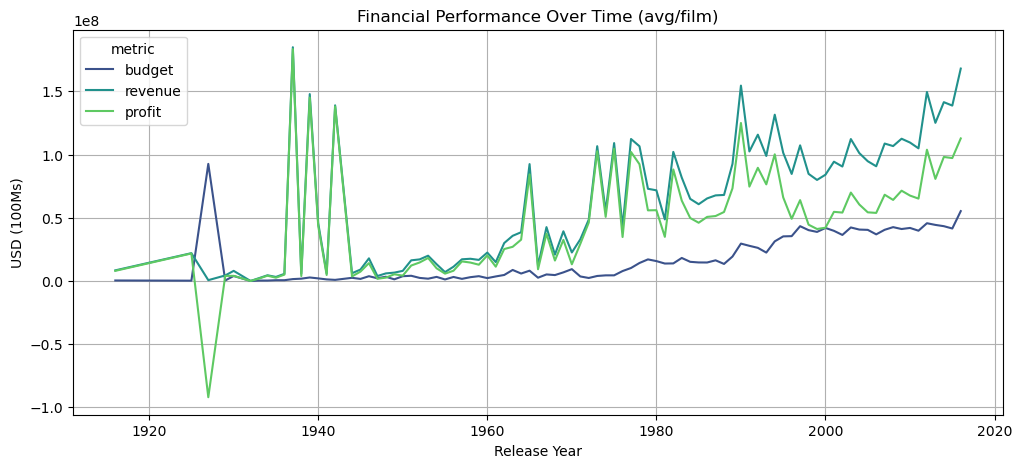

In [232]:
## Financial Performance Line Chart

rev_trends_filtered = df_finance_filt.groupby('release_yr')[['budget','revenue','profit']].mean().reset_index()

rev_melted = rev_trends_filtered.melt(id_vars='release_yr', 
                                      value_vars=['budget', 'revenue', 'profit'],
                                      var_name='metric', value_name='value')
plt.figure(figsize=(12,5))
sns.lineplot(
    data=rev_melted, 
    x='release_yr', 
    y='value', 
    hue='metric',
    palette='viridis'
)

plt.title("Financial Performance Over Time (avg/film)")
plt.xlabel("Release Year")
plt.ylabel("USD (100Ms)")
plt.grid(True)
plt.show()

<br>

**As we move towards modern data, we see greater stability and fewer outliers.** This can be attributed to the nature of the dataset, as there is a significant weighting towards more recently released films within.

Even so, a general trend of increasing spend on movie production coupled with a requisite increase in revenue and profit is evident in the data. We can also see that as we move into the modern era of cinema the delta between revenue and profit is increasing as budgets increase significantly.

When we look at the distribution of revenue/profit across the data set we see a positive correlations across multiple metrics:

- Revenue and Profit
- Release Date and Revenue
- Budget/Revenue and Release Date
<br>
<br>

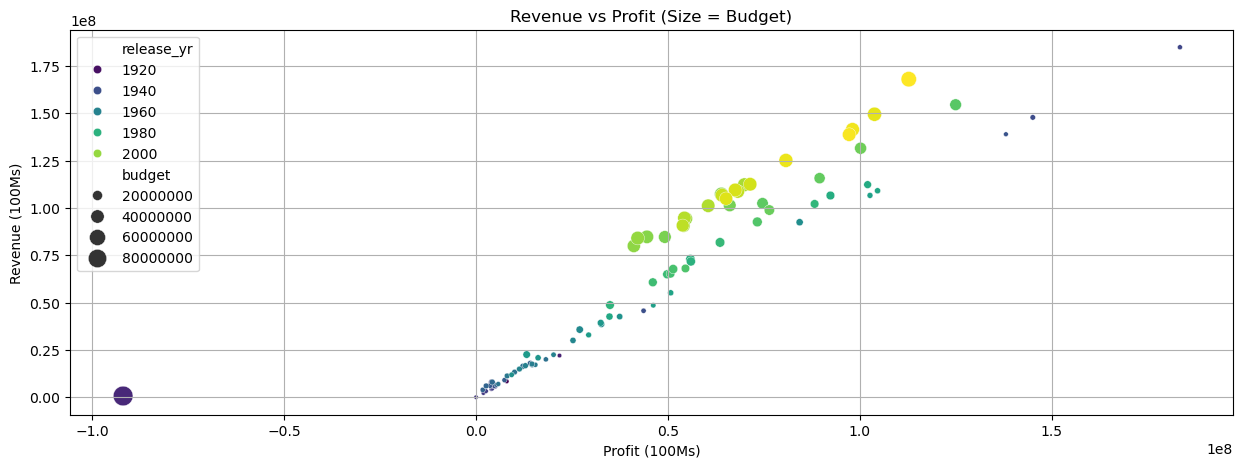

In [254]:
## Rev/Profit Scatterplot

plt.figure(figsize=(15,5))
sns.scatterplot(
    data=rev_trends_filtered, 
    x='profit', 
    y='revenue', 
    size='budget', 
    sizes=(10,200),
    hue='release_yr',
    palette='viridis'
)

plt.title('Revenue vs Profit (Size = Budget)')
plt.xlabel('Profit (100Ms)')
plt.ylabel('Revenue (100Ms)')
plt.grid(True)
plt.show()

<br> 

As you will have noted from the visualisations so far, we can see a few anomalies. The three spikes in revenue and profit around 1940 can be attributed to early Disney success from **Snow White** and **Bambi** as well as **Gone With The Wind**, all of which performed highly during a period where the overall data sample is smaller and more prone to spikes in performance. However, the other significant point is more interesting due to the scale of it's poor fit:  
<br>  
<center><img src="https://www.automachination.com/wp-content/uploads/2024/03/fritz-lang-metropolis-posters.jpg" width="600"></center> 
<br>

### Metropolis (1927)

*Metropolis* was considered a highly controversial film when it was released, with contemporaries considering it's political message and presentation to be highly charged. It was also very challenging to make, eventually costing more than *3 times* it's initial budget of 1.5 million Reichsmarks (***5.7m***) and making it the most expensive movie ever made at the time of release. Estimates adjusted for inflation put this figure today at around **$20m dollars**.

In the years since, the mystique around the film has ballooned reported figures up to around **$200m**, although there is no data to back this figure up. When we look at the data in our table we can see we might have a similar situation here.

Utilizing 1960 as a cutoff in line with our graph above, we can see:  
<br>

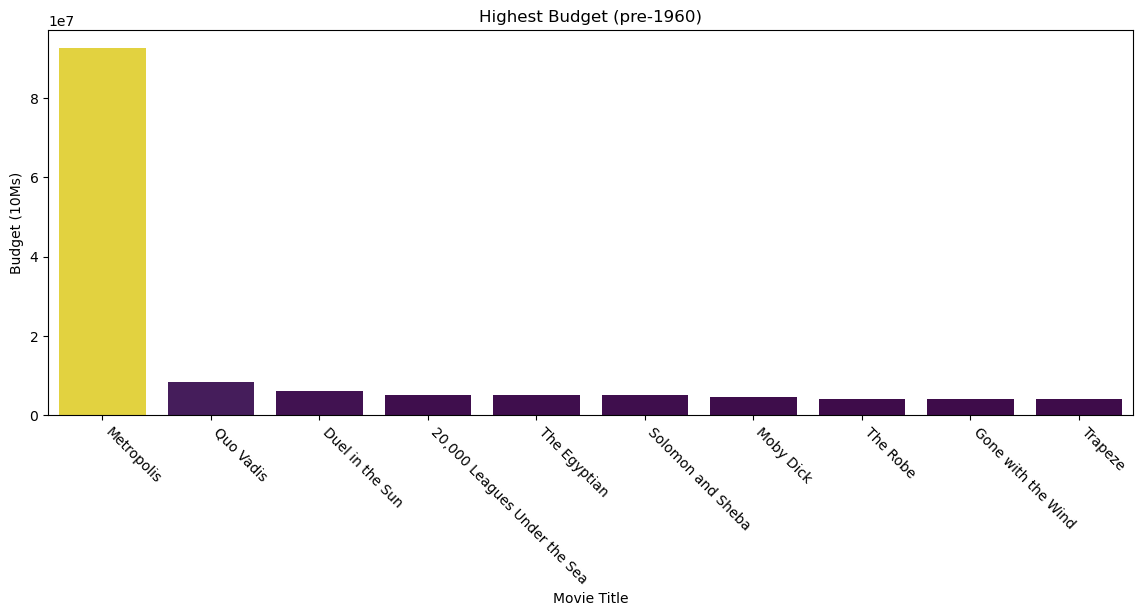

In [233]:
## Pre-1960s Budget Bar Chart

early_years = df_finance_filt.loc[df_finance_filt['release_yr'] < 1960,['title', 'budget', 'release_yr']]  # filtering to remove more recent films
early_years = early_years.sort_values('budget', ascending = False).head(10)

plt.figure(figsize=(14,5))
sns.barplot(
    data=early_years, 
    y='budget', 
    x='title', 
    hue='budget',
    palette='viridis',
    legend=False
)

plt.xticks(rotation=-45, ha='left')
plt.title('Highest Budget (pre-1960)')
plt.xlabel('Movie Title')
plt.ylabel('Budget (10Ms)')
plt.show()

<br>

Not only is *Metropolis* reporting a significantly higher budget than any other contemporary film, the data contained within the table appears to be highly anomalous with historical records. **As a result, we would recommend correcting or removing this datapoint from the data**

While *Metropolis* was heavily criticised during it's initial run, in the years since it has come to be recognized as a seminal part of the history of cinema, specifically with it's approach to visual effects, production techniques and aesthetics. So how does it stack up according to our data?  

## Ratings & Popularity

In order to evaluate this, let's take a look at our highest rated movies. **Note that we have used the median count of votes in order to remove movies with a low overall vote count**. The median was chosen as a restrictor to avoid omissions being impacted specifically by movies with a much larger overall count:  
<br>

In [240]:
## Highest Avg. Rating Table

median_vc = df.vote_count.median()                   # calculating median vote count
df_pop = df.loc[df.vote_count > median_vc]           # filtering average to remove low counts

df_pop_votes = df_pop[['title', 'vote_average', 'vote_count', 'popularity']].sort_values(by='vote_average', ascending=False).head(10)
df_pop_votes

,title,vote_average,vote_count,popularity
1881,The Shawshank Redemption,8.5,8205,136.747729
3337,The Godfather,8.4,5893,143.659698
2294,Spirited Away,8.3,3840,118.968562
3232,Pulp Fiction,8.3,8428,121.463076
662,Fight Club,8.3,9413,146.757391
1818,Schindler's List,8.3,4329,104.469351
3865,Whiplash,8.3,4254,192.528841
2731,The Godfather: Part II,8.3,3338,105.792936
1847,GoodFellas,8.2,3128,63.654244
3057,American History X,8.2,3016,73.567232


<br>

Unfortunately, *Metropolis* just misses out her with an average rating of 8.0, but we can see that the above list is a strong representation of films produced across the past century. However, a quick glance demonstrates an interesting note: when we map these metrics across from each other, we can see that ***there is a less strong correlation between rating and popularity than there was for financial performance***:  
<br>  

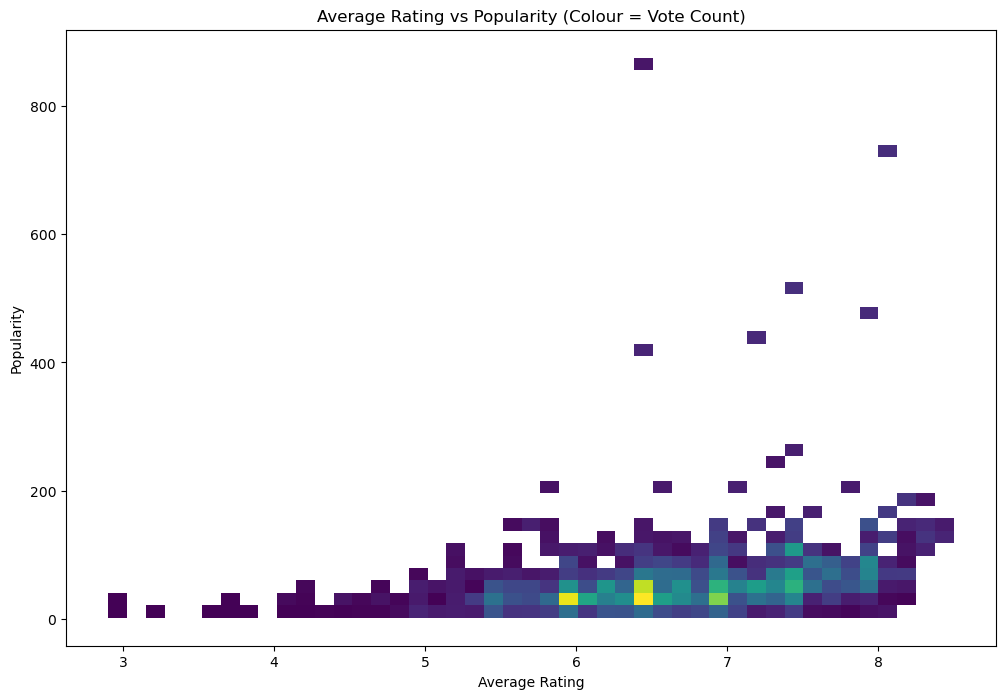

In [237]:
## Avg. Rating Heatmap

plt.figure(figsize=(12, 8))

sns.histplot(
    data=df_pop,
    x='vote_average',
    y='popularity',
    weights='vote_count',  # color intensity = vote_count
    bins=45,
    cmap='viridis'
)

plt.title('Average Rating vs Popularity (Colour = Vote Count)')
plt.xlabel('Average Rating')
plt.ylabel('Popularity')
plt.show()

We can still see a general trend of positive correlation, but overall we see a much more constrained delta for popularity across most of our films, while a few jump out across the data set. We can also see that there is a concentration of films with a **higher number of overall votes/ratings centralised within the mapped data** as indicated by the warmer colours massed in the bottom right of the chart.

Interestingly, none of the top films by rating appear as high in the popularity table, although there are still a number of highly rated films at the top of the list. As we can see from the chart below however, ratings around 6.4-6.8 are middle-of-the-road when we consider the whole dataset:  
<br>

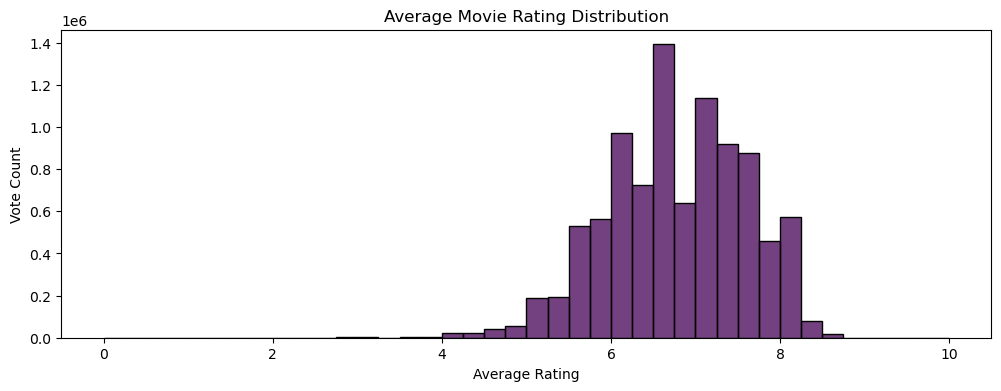

In [257]:
## Avg. Rating Histogram

plt.figure(figsize=(12,4))
sns.histplot(
    data=df_genres, 
    x="vote_average", 
    bins=40,
    weights='vote_count',
    color=cm.viridis(0.0)
)

plt.title('Average Movie Rating Distribution')
plt.xlabel('Average Rating')
plt.ylabel('Vote Count')
plt.show()

In [239]:
## Popularity Ratings Table

df_pop_pop = df_pop[['title', 'vote_average', 'vote_count', 'popularity']].sort_values(by='popularity', ascending=False).head(10)
df_pop_pop

,title,vote_average,vote_count,popularity
546,Minions,6.4,4571,875.581305
95,Interstellar,8.1,10867,724.247784
788,Deadpool,7.4,10995,514.569956
94,Guardians of the Galaxy,7.9,9742,481.098624
127,Mad Max: Fury Road,7.2,9427,434.278564
28,Jurassic World,6.5,8662,418.708552
199,Pirates of the Caribbean: The Curse of the Bla...,7.5,6985,271.972889
82,Dawn of the Planet of the Apes,7.3,4410,243.791743
200,The Hunger Games: Mockingjay - Part 1,6.6,5584,206.227151
88,Big Hero 6,7.8,6135,203.734590


<br>
In order to understand this discrepancy better, we have chosen to do a brief exploration of performance and significance based on genre categorisation.

### Genre Breakdown 

In order to evaluate our most popular movie, we have pulled out the individual genre classifications to see if we can find any patterns. Below are the four genre categories assigned to *Minions*  
<br>

In [241]:
## Minions Genre Categorisation
## Sorting JSON data to provide breakdown of genres by film

df['genre_name'] = df.genres.str.findall(r'"name": "([^"]+)"')       # identifying and isolating genre names from genres column
df_genres = df.explode('genre_name')                                 # creating an individual row for each genre classification by film

genre_count = df_genres.groupby(['genre_name', 'decade']).size().reset_index(name='count')
genre_pivot = genre_count.pivot(index='genre_name', columns = 'decade', values = 'count').fillna(0)

df_genres.loc[df_genres['title'].isin(['Minions']), ['title', 'genre_name']] # pulling out data on 'Minions' to inform further investigation

,title,genre_name
546,Minions,Family
546,Minions,Animation
546,Minions,Adventure
546,Minions,Comedy


<br>  
First, let's look at the overall genre distribution for all movies across the dataset. Doing this allows us to understand whether there is any pattern with more common genres account for more popular movies.  
<br>  
<br>  

**The table below shows a gradient chart by decade of all genre classifications**. Obviously we can see that as the number of movies accounted for increases we see a general growth in distribution, but specifically we have notable spikes for the following genres:  

- Action
- Comedy
- Drama
- Thriller  
<br>


This makes intuitive sense when you think about the landscape of modern cinema, but how does that apply to our popularity leaders?  
<br>

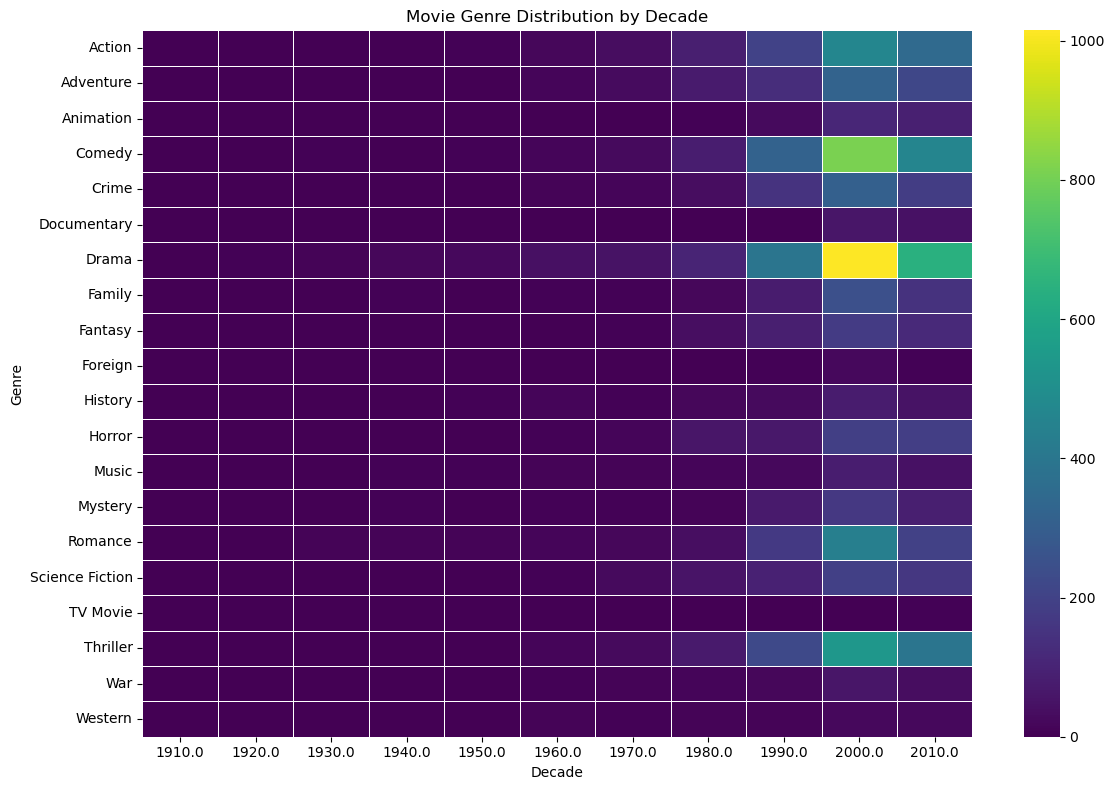

In [242]:
## Genre Distribution Heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(
    genre_pivot, 
    cmap='viridis', 
    linewidths=0.5
)

plt.title("Movie Genre Distribution by Decade")
plt.xlabel("Decade")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

In [253]:
## Popular Movie Genre Counts

genre_df = df_genres.loc[
    df_genres['title'].isin([
        'Minions',
        'Interstellar',
        'Deadpool',
        'Guardians of the Galaxy',
        'Mad Max: Fury Road',
        'Jurassic World',
        'Pirates of the Caribbean: The Curse of the Black Pearl',
        'Dawn of the Planet of the Apes',
        'The Hunger Games: Mockingjay - Part 1',
        'Big Hero 6'
    ]), 'genre_name'].value_counts().reset_index(name='count')    # reseting index to count appearances of each genre

genre_df

,genre_name,count
0,Adventure,9
1,Action,7
2,Science Fiction,6
3,Thriller,4
4,Comedy,3
5,Drama,2
6,Family,2
7,Animation,2
8,Fantasy,1


<br>  

So what we can see from our the above is that **only 2 of our most popular movies are drawn from our most popular genre over the past 3 decades** (Drama). We do see a lot of Action films in the group, as well as a mix across other higher produced categories (such as Thrillers and Comedies), but there is less of a correlation with volume of movies produced for popularity.

We also see an over-index of Sci-Fi compared to volume, which is likely a result of the boom of Comic Book movies and the adaptation trend that has followed that movement. There does not appear to be a specific relationship with saturation and popularity. As such, let's evaluate *Minions* on it's own merits. The boxplot below shows average rating by genre. **The red line indicates *Minions* rating**:  
<br>

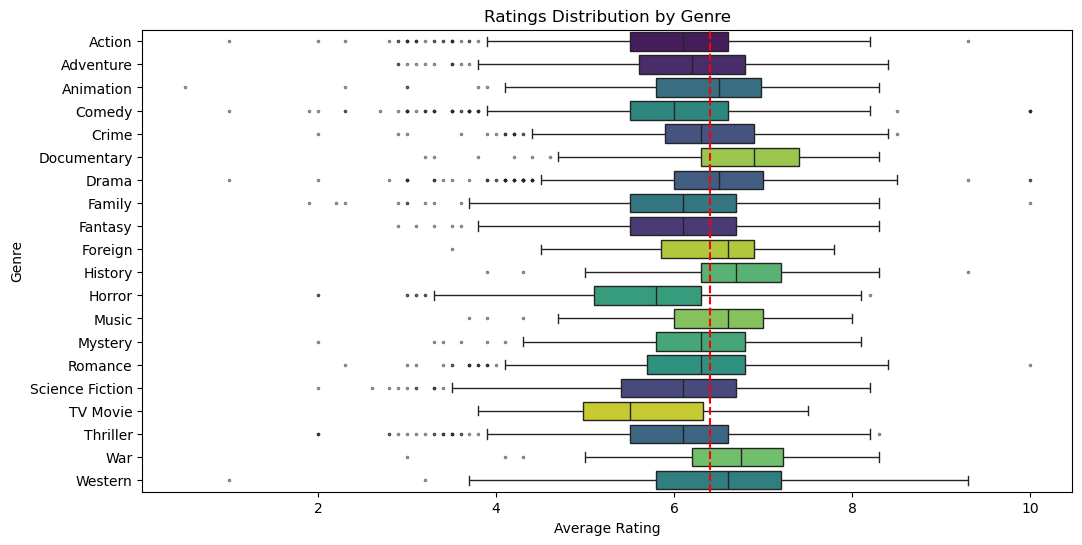

In [243]:
## Ratings Distribution by Genre
## Compiling and counting genre combinations across all films

df_genres = df_genres.reset_index(drop=True)                      # reseting index to remove duplicate titles
df_genres = df_genres.dropna(subset=['genre_name'])
df_genres_filt = df_genres[df_genres['vote_average'] > 0]         # removing zeros from vote average to reduce unnecessary noise in plot

order = sorted(df_genres_filt['genre_name'].unique())             # order alphabetically

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_genres_filt,
    y='genre_name',
    x='vote_average',
    order=order,
    palette='viridis',
    hue='genre_name',
    legend=False,
    flierprops={
        'marker': '.',
        'markersize': 3, 
        'alpha': 0.6 
    }
)

plt.axvline(
    x=6.4,
    color='red',
    linestyle='--',
    linewidth=1.5,
    label='Minions 6.4'
)

plt.title('Ratings Distribution by Genre')
plt.ylabel('Genre')
plt.xlabel('Average Rating')
plt.show()

###### *note: average ratings of 0 have been removed from the data contained above*
<br>  
As a brief reminder, *Minions* has the following genre classifications:
<br>  
<br>  

> Adventure  
> Animation  
> Comedy  
> Family

<br>  
We can see above that our most popular film achieve an above average rating in 3 of those four genres, with Animation being the exception. So while it is not one of our top rated movies, we have a perfectly serviceable, family-friendly smash hit that people seem to love. Our analysis suggests *that* is the main reason for it's popularity:  
<br>  
<br>  
<br>
<center><img src="https://images.unsplash.com/photo-1555786766-e1e69380c4bc?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=1468" width="800">

###### Couldn't possibly be anything else, right?</center>

## Conclusion

To conclude, our initial analysis has produced the following insights:

* **Movies are making on average *more* revenue and profit as we move forward in time**
 
* **Scaling of profit is not comensurate with increased revenue as a result of inflated budgets in modern filmmaking**
 
* **Our dataset requires additional work to improve accuracy, and potentially fact checking if our individual investigation is correct**
 
* **The most *popular* movies are not necessarily those with the highest ratings and reviews**